<a href="https://colab.research.google.com/github/wenxuan0923/My-notes/blob/master/Data_Augmentation_ImageDataGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What does data augmentation do?

Overfitting is caused by having too few samples to learn from, such that the model is not able to generalize to new data. However, obtaining more data are not always achievable or possiblein, we may only have access to very limit amount of data. **Data Augmentation** is a way to generate more **virtual** training data from the existing samples through random transformation includes rotation, zooming, etc. This way the learned model may be more robust and accurate as it is trained on different variations of the same image. This process can be done by configuring the parameters in `ImageDataGenerator` instances. <br>

Note `ImageDataGenerator` will **NOT** add new images to your data set in a sense that it will not make the epochs bigger. Instead, in each epoch it will provide slightly altered images (depending on the configuration). It will always generate new images, no matter how many epochs you have.


The data used for this note is available here:
[Dogs v.s. Cats datset](https://www.kaggle.com/c/dogs-vs-cats/data)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [15]:
base_dir = '/content/drive/My Drive/Colab Notebooks/kaggle_data/dog_cat'
train_dir = os.path.join(base_dir, 'train')
train_imgs = [f for f in os.listdir(train_dir) if f.endswith('.jpg')]
train_info = list(map(lambda x: {'label':x.split('.')[0], 'filename': x}, 
                      train_imgs))
train_df = pd.DataFrame(train_info)
train_df.head()

,label,filename
0,cat,cat.9587.jpg
1,cat,cat.9556.jpg
2,cat,cat.9572.jpg
3,cat,cat.9561.jpg
4,cat,cat.957.jpg


### Setting up a data augmentation configuration via ImageDataGenerator

In [0]:
from keras.preprocessing import image
from keras.preprocessing.image import load_img, ImageDataGenerator

Let's take a look at a random image in training set

File Name: cat.9886.jpg


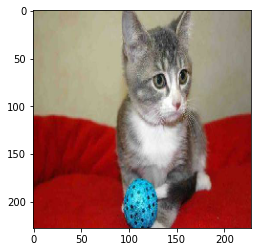

In [78]:
n = 349
img = load_img(
    os.path.join(train_dir, train_df.filename[n]),
    target_size=(228, 228)
    )
print('File Name:', train_df.filename[n])
plt.imshow(img)
plt.show()

In [66]:
x = image.img_to_array(img)
print(x.shape)

(228, 228, 3)


In [67]:
# convert to 4D tensor
x = x.reshape((1, 228, 228, 3))
print(x.shape)

(1, 228, 228, 3)


`ImageDataGenerator` generates batches of tensor image data with real-time data augmentation. The data will be looped over (in batches). At every new epoch new random transformations will be applied and this way we train with a little different et of images at a time.

In [0]:
datagen = ImageDataGenerator(
    rescale = 1./255,          # Scale images from integers 0-255 to floats 0-1
    rotation_range = 30,       # Int. Degree range for random rotations
    width_shift_range = 0.1,   # Float: fraction of total width, if < 1
    height_shift_range = 0.1, 
    shear_range = 0.2,         # Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    zoom_range = 0.2,          # Float or [lower, upper]. Range for random zoom
    horizontal_flip = True,
    fill_mode = 'nearest')     # Method used to fill the newly created pixels

`datagen.flow` generates batches of randomly transformed images. 
It loops indefinitely, so you need to break the loop at some point!

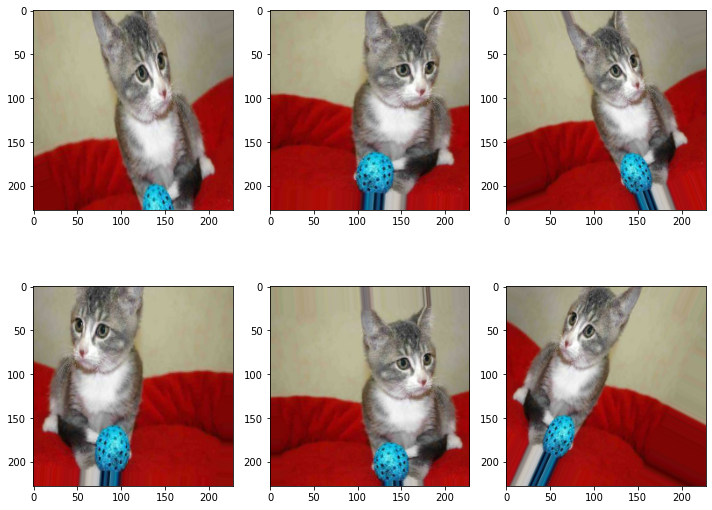

In [80]:
i = 1
fig = plt.figure(figsize=(10, 8))
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(2, 3, i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 7 == 0:
      break
plt.tight_layout()
plt.show()

Because we set the `batch_size` to be 1 and there is only one sample defined by variable `x`, the `datagen.flow` method will loop through this 1 sample over and over (infinitely). Each of the 6 transformed images above is actually 1 sample for 6 epochs.

### To train your DL model with augmented data:

For example, you have a CNN model constructed this way:

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop', 
    metrics=['acc'])

In [0]:
train_generator = datagen.flow_from_dataframe(
        dataframe = train_df,
        directory = train_dir,
        x_col = "filename",
        y_col = "label",
        target_size = (150, 150),
        batch_size = 50,
        class_mode='binary')

Because the data is being generated endlessly, the Keras model
needs to know how many samples to draw from the generator before declaring an
epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator—that is, after having run for `steps_per_epoch` gradient descent steps—the fitting process will go to the next epoch. In this case, batches are 50 samples, so it will take 500 batches until you see your target of 25000 samples. 

That means you need to set the `steps_per_epoch` argument of fit method to `n_samples / batch_size`, where `n_samples` is the total number of training data you have. This way in each epoch, each training sample is augmented only one time and therefore `n_samples` transformed images will be generated in each epoch.

In [81]:
print(len(train_df))

25000


In [84]:
25000//50

500

In [0]:
history = model.fit_generator(
  train_generator,
  epochs = 50,
  steps_per_epoch=500) # Number of batches for each epoch
